In [1]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torchvision
import torchvision.transforms.v2 as v2
from torchmetrics.functional import pairwise_cosine_similarity

import numpy as np
import pandas as pd
import math
from pathlib import Path
from collections import Counter
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.colors as mcolor
import random
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
import sys

sys.path.append('./src')
from src.data import MultiSet, multi_collate
from src.models import TS_BERT, CLIP

from accelerate import Accelerator
from accelerate.utils import GradientAccumulationPlugin

import scienceplots

plt.style.use('science')

plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times"],
    "font.size": 12
})

In [2]:
data_path = Path('./data/CytoSense')
annotation = 'train_4'

dataset = MultiSet(data_path=data_path, annotation=annotation)

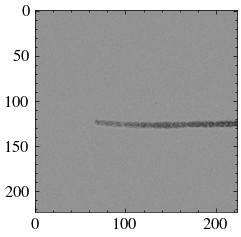

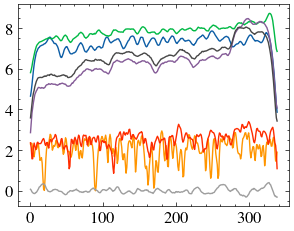

1998

In [3]:
ix = 53

image, signal, y = dataset[ix]

plt.imshow(image.permute(1, 2, 0))
plt.show()
plt.plot(signal)
plt.show()
dataset.X[ix]

## Cross-Modality Training

In [4]:
collate_bert = lambda batch: multi_collate(batch, bert=True)
dataloader = DataLoader(dataset=dataset, batch_size=20, 
                        shuffle=True, num_workers=8, 
                        drop_last=True, collate_fn=collate_bert)
print(f'{len(dataloader) = }')

signal_encoder = TS_BERT()

image_encoder = torchvision.models.resnet18()
image_encoder.fc = nn.Linear(512, 512)

clip = CLIP(image_encoder, signal_encoder)

optimizer = optim.Adam(clip.parameters(), lr=1e-4, weight_decay=1e-9)

plugin = GradientAccumulationPlugin(num_steps=10, sync_with_dataloader=False)
accelerator = Accelerator(mixed_precision='fp16', gradient_accumulation_plugin=plugin)
clip, optimizer, dataloader = accelerator.prepare(clip, optimizer, dataloader)

losses = []

len(dataloader) = 20


In [5]:
sum(p.numel() for p in clip.model_1.parameters()), \
    sum(p.numel() for p in clip.model_2.parameters())


(11439168, 8415232)

In [6]:
epochs = 15
steps = len(dataloader) * epochs
iterator = tqdm(range(1, steps + 1))

generator = iter(dataloader)

accum_steps = accelerator.gradient_accumulation_steps
accumulated_loss = 0

clip.train()

for i in iterator:

    try:
        image, signal, y = next(generator)
    except StopIteration:
        generator = iter(dataloader)
        image, signal, y = next(generator)

    with accelerator.accumulate(clip):
        optimizer.zero_grad()
        _, _, loss = clip(image, signal)
        accelerator.backward(loss)
        optimizer.step()
        accumulated_loss += loss.detach().item()

    if i % accum_steps == 0:
        accumulated_loss /= accum_steps
        losses.append(accumulated_loss)
        iterator.set_description(f'{accumulated_loss = :.5f}')
        accumulated_loss = 0


accumulated_loss = 2.42176: 100%|██████████| 300/300 [00:34<00:00,  8.80it/s]


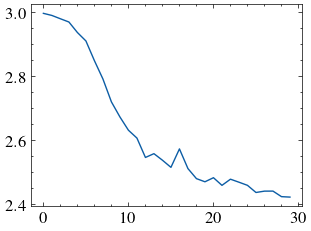

In [7]:
plt.plot(losses)

In [8]:
clip.logit_scale

Parameter containing:
tensor(1.0028, device='cuda:0', requires_grad=True)

In [9]:
test_set = MultiSet(data_path, 'test_4')
test_set.label_encoder = dataset.label_encoder
test_loader = DataLoader(test_set, 20, collate_fn=collate_bert)
test_loader = accelerator.prepare(test_loader)

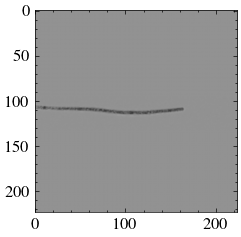

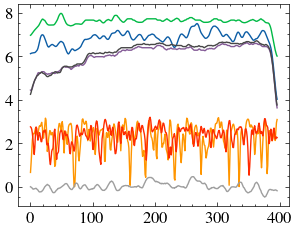

(292, 397)

In [10]:
ix = 979

image, signal, y = test_set[ix]

plt.imshow(image.permute(1, 2, 0))
plt.show()
plt.plot(signal)
plt.show()
test_set.X[ix], len(signal)

In [11]:
clip.eval()

I_e = []
S_e = []
label = []
test_losses = []

for image, signal, y in tqdm(test_loader):
    with torch.no_grad():
        encoding_1, encoding_2, loss = clip(image, signal)
        I_e.append(encoding_1.cpu())
        S_e.append(encoding_2.cpu())
        label.append(y.cpu())
        test_losses.append(loss.detach().item())

I_e = torch.cat(I_e)
S_e = torch.cat(S_e)
label = torch.cat(label)

print(f'Loss = {np.mean(test_losses)}')

100%|██████████| 196/196 [00:11<00:00, 17.41it/s]

Loss = 2.979759118994888


In [12]:
I_e_np = I_e.numpy()
S_e_np = S_e.numpy()
label_np = label.numpy()

from sklearn.manifold import TSNE

E = TSNE(2, perplexity=10, early_exaggeration=20).fit_transform((I_e_np + S_e_np) / 2)

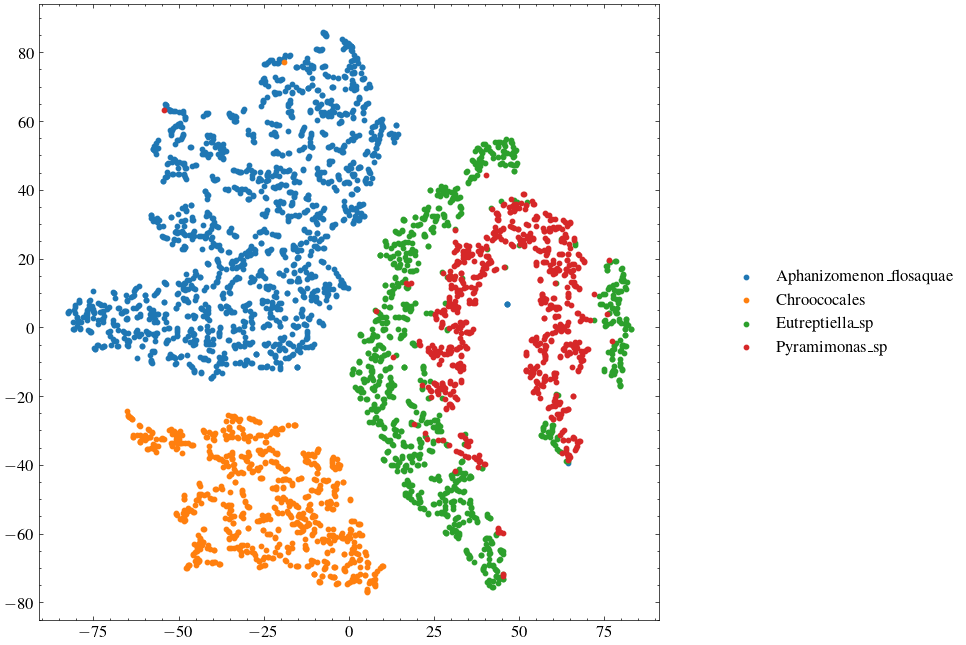

In [13]:
fig, ax = plt.subplots()

for y, c in zip(np.unique(label_np), mcolor.TABLEAU_COLORS.values()):
    class_name = test_set.label_encoder.inverse_transform([y])[0]
    e = E[label == y]
    ax.scatter(*zip(*e), label=class_name, s=10, c=c)


fig.set_size_inches(8, 8)
ax.legend(loc=7, bbox_to_anchor=(1.5, .5))
plt.show()

## Training the classifier

In [39]:
classifier = nn.Sequential(
    nn.Linear(512, 1024),
    nn.GELU(),
    nn.Linear(1024, 1024),
    nn.GELU(),
    nn.Linear(1024, 1024),
    nn.GELU(),
    nn.Linear(1024, 1024),
    nn.GELU(),
    nn.Linear(1024, 4)
)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=1e-4, weight_decay=1e-9)
classifier, optimizer = accelerator.prepare(classifier, optimizer)

losses = []

In [40]:
epochs = 20
steps = len(dataloader) * epochs
iterator = tqdm(range(1, steps + 1))

generator = iter(dataloader)

clip.eval()
classifier.train()
accumulated_loss = 0
accum_steps = accelerator.gradient_accumulation_steps
accum_steps
for _ in iterator:

    try:
        image, signal, y = next(generator)
    except StopIteration:
        generator = iter(dataloader)
        image, signal, y = next(generator)

    with torch.no_grad():
        encoding_1, encoding_2, _ = clip(image, signal)

    x = (encoding_1 + encoding_2) / 2

    with accelerator.accumulate(classifier):
        optimizer.zero_grad()
        out = classifier(x)
        loss = criterion(out, y)
        accelerator.backward(loss)
        optimizer.step()
        accumulated_loss += loss.detach().item()

    if i % accum_steps == 0:
        losses.append(accumulated_loss)
        iterator.set_description(f'{accumulated_loss = :.5f}')
        accumulated_loss = 0


accumulated_loss = 0.43325: 100%|██████████| 400/400 [00:26<00:00, 15.30it/s]


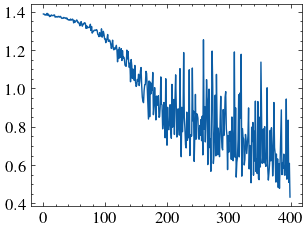

In [41]:
plt.plot(losses)

In [42]:
x = (I_e + S_e).div(2).to(accelerator.device)

with torch.no_grad():
    pred = classifier(x).cpu().argmax(1)

pred


tensor([0, 0, 0,  ..., 3, 3, 3])

In [43]:
from sklearn.metrics import classification_report

names = test_set.label_encoder.inverse_transform(list(range(4)))
pd.DataFrame(classification_report(label, pred, target_names=names, output_dict=True)).T

,precision,recall,f1-score,support
Aphanizomenon_flosaquae,0.998707,0.991020,0.994849,1559.000000
Chroococales,0.904821,0.997275,0.948801,734.000000
Eutreptiella_sp,0.894737,0.018559,0.036364,916.000000
Pyramimonas_sp,0.446920,0.985549,0.614968,692.000000
accuracy,0.762881,0.762881,0.762881,0.762881
macro avg,0.811296,0.748101,0.648745,3901.000000
weighted avg,0.858747,0.762881,0.693734,3901.000000


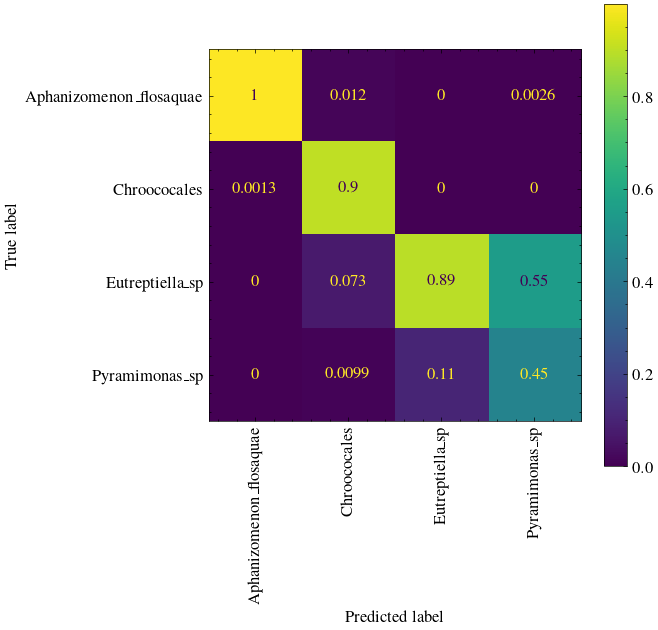

In [44]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

fig, ax = plt.subplots()
cm = confusion_matrix(label, pred, normalize='pred')
ConfusionMatrixDisplay(cm, display_labels=names).plot(xticks_rotation='vertical', ax=ax)
fig.set_size_inches(6, 6)

